# SD212: Graph mining
## Lab 7: Graph embedding

In this lab, you will learn to embed the nodes of a graph in a vector space of low dimension.

## Import

In [1]:
from IPython.display import SVG

In [2]:
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt

In [3]:
from sknetwork.data import load_netset, karate_club
from sknetwork.embedding import Spectral, BiSpectral  # the target class
from sknetwork.linalg import HalkoEig
from sknetwork.ranking import top_k
from sknetwork.utils import KMeansDense
from sknetwork.visualization import svg_graph

## Pre-lab

In [12]:
# answering the quiz:
P = np.array([[0, 1/2, 0, 0, 0, 1/2],
              [1/2, 0, 1/2, 0, 0, 0],
              [0, 1/2, 0, 1/2, 0, 0],
              [0, 0, 1/2, 0, 1/2, 0],
              [0, 0, 0, 1/2, 0, 1/2],
              [1/2, 0, 0, 0, 1/2, 0]])
np.linalg.eig(P)
HalkoEig(P)

HalkoEig(which=[[0.  0.5 0.  0.  0.  0.5]
 [0.5 0.  0.5 0.  0.  0. ]
 [0.  0.5 0.  0.5 0.  0. ]
 [0.  0.  0.5 0.  0.5 0. ]
 [0.  0.  0.  0.5 0.  0.5]
 [0.5 0.  0.  0.  0.5 0. ]], n_oversamples=10, n_iter='auto', power_iteration_normalizer='auto', one_pass=False)

## Data

We will work on the following graphs (see the [NetSet](https://netset.telecom-paristech.fr/) collection for details):
* Openflights (graph)
* WikiVitals (directed graph and bipartite graph)

In [8]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')

Parsing files...
Done.
Parsing files...
Done.


## 1. Graphs

## Karate Club


We first consider the spectral embedding of the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

In [8]:
graph = karate_club(True)

In [9]:
adjacency = graph.adjacency
position = graph.position
labels_true = graph.labels

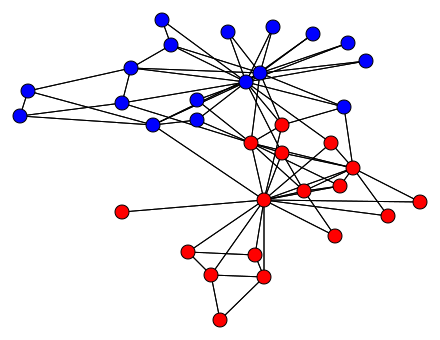

In [10]:
image = svg_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Display the spectrum of the transition matrix (e.g., first 20 eigenvalues). 
* What does the spectrum suggest?
* Display the graph with the embedding in dimension 2.
* Check that the embedding weighted by the degrees is centered and that the components have the same variance.
* How many nodes are misclassified using the sign of the first eigenvector? What are these nodes?

In [88]:
K = 20
spectral = Spectral(K, normalized=False, regularization=None, scaling=0)

In [89]:
spectral.fit(adjacency)

Spectral(n_components=20, regularization=None, relative_regularization=True, scaling=0, normalized=False, solver='auto')

#### Spectrum of the transition matrix:

In [38]:
eigenvalues = spectral.eigenvalues_
sorted(eigenvalues)

[-2.3205142516878743e-18,
 -1.5282106142334895e-18,
 -2.576004714695987e-33,
 -1.3169144045281777e-33,
 -4.255233050576897e-34,
 1.5931876301154653e-33,
 2.7292033734085e-33,
 7.932371224930392e-19,
 1.4092558949138468e-16,
 0.09318399841352494,
 0.1351670554193802,
 0.17705714766180972,
 0.2290893831488694,
 0.26004201069915783,
 0.2927917975058478,
 0.35100705333079996,
 0.3877694597996918,
 0.6126867673898702,
 0.7129510146149639,
 0.8677276707704836]

The spectrum suggests that there are there is around 9 clusters (connected components), since we have 9 different eigenvalues almost equal to 0.

In [39]:
embedding = spectral.embedding_

#### Checking conditions on the 20-D embedding:

In [43]:
d = adjacency.dot(np.ones(adjacency.shape[0]))
embedding.T.dot(d)

array([-3.28903571e-15, -1.79717352e-15,  1.84574578e-15,  6.50521303e-17,
        1.71737624e-16,  5.97612237e-16,  4.16333634e-17, -1.31838984e-16,
       -9.02056208e-17,  7.70217223e-16,  1.99840144e-15,  1.25825357e-15,
       -5.64972647e-16,  3.50192103e-17,  2.89234280e-16,  2.02028393e-17,
        8.95979552e-16, -7.41326140e-16,  3.25914353e-16, -2.59071687e-16])

In [73]:
cov = embedding.T.dot(np.diag(d).dot(embedding))
np.sum(np.eye(20)-np.abs(cov))

-3.1253415799324915e-14

We conclude:
* The embedding weighted by degrees is null (condition 1 verified)
* The covariance matrix weighted by the degree is the unity matrix (close to 1e-15)

#### 2-D embedding:

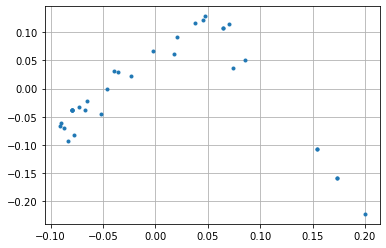

In [74]:
K = 2
spectral = Spectral(K, normalized=False, regularization=None, scaling=0)
spectral.fit(adjacency)
embedding = spectral.embedding_
X = spectral.embedding_[:,0]
Y = spectral.embedding_[:, 1]
plt.plot(X, Y, ".")
plt.grid()

#### Checking conditions on the 20-D embedding:

In [75]:
d = adjacency.dot(np.ones(adjacency.shape[0]))
embedding.T.dot(d)

array([ 2.88657986e-14, -4.42007542e-15])

In [77]:
cov = embedding.T.dot(np.diag(d).dot(embedding))
np.sum(np.eye(2)-np.abs(cov))

8.326672684688674e-16

We conclude:
* The embedding weighted by degrees is null (condition 1 verified)
* The covariance matrix weighted by the degree is the unity matrix (close to 1e-16)

#### Labels based of the sign of the first eigenvlue:

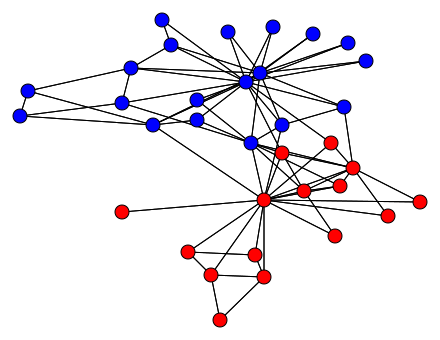

In [81]:
labels = embedding[:, 0]>0
image = svg_graph(adjacency, position, labels=labels)
SVG(image)

In [85]:
print("we have", sum(labels != labels_true), "misclassified labels")

we have 2 misclassified labels


the misclassified labels, are the usual ones: [2 8]


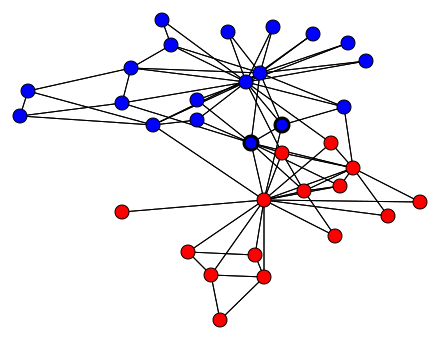

In [87]:
miss = np.where(labels != labels_true)[0]
print("the misclassified labels, are the usual ones:", miss)
labels = embedding[:, 0]>0
image = svg_graph(adjacency, position, labels=labels, seeds=miss)
SVG(image)

## Openflights


We now consider a larger graph. We use the Laplacian eigenmap in dimension 20. We measure proximity between nodes in terms of [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). Equivalently, we work on the embedding in the unit sphere, which can be obtained through the parameter ``normalized`` of the class ``Spectral``.

In [226]:
graph = openflights

In [227]:
adjacency = graph.adjacency
position = graph.position
names = graph.names

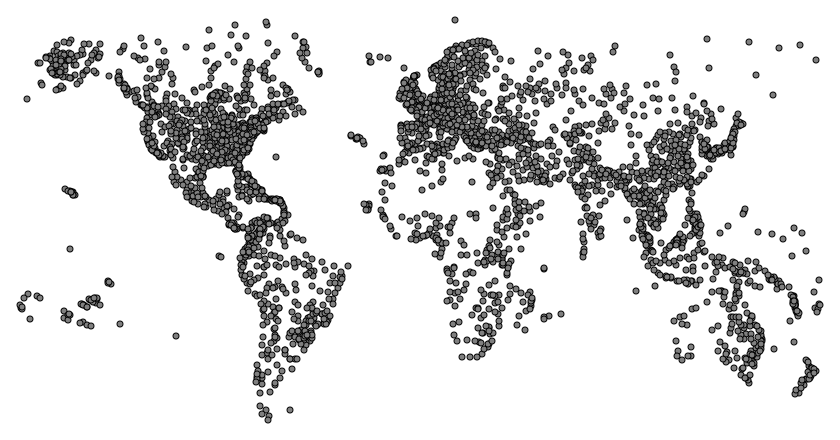

In [228]:
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the spectrum of the normalized Laplacian.
* Display the same world map with the scores equal to the cosine similarity to **Beijing** in the embedding space.
* List the 10 closest airports to **Madrid** in terms of cosine similarity in the embedding space.
* Display the same world map with 8 clusters found by k-means in the embedding space (still using cosing similarity).

#### Spectrum of the normalized Laplacian

In [229]:
spectral = Spectral(20, normalized=True, regularization=None, scaling=0)
spectral.fit(adjacency)
embedding = spectral.embedding_
spectral.eigenvalues_

array([0.97054217, 0.96132918, 0.95733733, 0.94469343, 0.93264773,
       0.9274875 , 0.91441796, 0.89991794, 0.89525098, 0.88668716,
       0.86282967, 0.8366441 , 0.80901524, 0.79873774, 0.77044436,
       0.73694796, 0.65263921, 0.60305417, 0.55980649, 0.53013009])

#### Cosine similarity to Beijing

In [230]:
def cos_similarity(v0, v):
    # N.B.: normV0 and normV will be equal to 1 if the spectral model is normalized
    #       in that case, cos_similarity(v0, v) == v0.dot(v)
    normV0 = np.linalg.norm(v0)
    normV = np.linalg.norm(v)
    prod = v0.dot(v)
    return prod/(normV0*normV)

In [65]:
beijing = 1618
beijing_embed = embedding[beijing]
sim = []
for v in embedding:
    sim.append(cos_similarity(beijing_embed, v))
sim = np.array(sim)

In [66]:
# another way to get the cosine similarities:
scores = embedding.dot(embedding[beijing])

In [69]:
-1*np.sort(-scores)

array([ 1.        ,  0.99586414,  0.99578552, ..., -0.29406089,
       -0.29587087, -0.32908559])

In [67]:
-1*np.sort(-sim)

array([ 1.        ,  0.99586414,  0.99578552, ..., -0.29406089,
       -0.29587087, -0.32908559])

#### Closest airports to Madrid by cosine similarity

In [15]:
madrid = 572
madrid_embed = embedding[madrid]
ranks = []
for v in embedding:
    ranks.append(cos_similarity(madrid_embed, v))
ranks = np.array(ranks)
for port in names[np.argsort(-ranks)][:11]:
    print(port)

Adolfo Suárez Madrid–Barajas Airport
Logroño-Agoncillo Airport
Pamplona Airport
San Sebastian Airport
Badajoz Airport
Tenerife Norte Airport
A Coruña Airport
La Gomera Airport
Manchester Airport
London Gatwick Airport
Federico Garcia Lorca Airport


#### For quiz, Tokyo:

In [224]:
for i, name in enumerate(names):
    if 'okyo' in name:
        tokyo = i

In [231]:
tokyo_embed = embedding[tokyo]
ranks = []
for v in embedding:
    ranks.append(cos_similarity(tokyo_embed, v))
ranks = np.array(ranks)
for port in names[np.argsort(-ranks)][:11]:
    print(port)

Tokyo Haneda International Airport
Oita Airport
Miho Yonago Airport
Kushiro Airport
Matsuyama Airport
Miyazaki Airport
Saga Airport
Komatsu Airport
Miyako Airport
New Chitose Airport
Noto Airport


#### K-Means with cosine similarity on the graph:

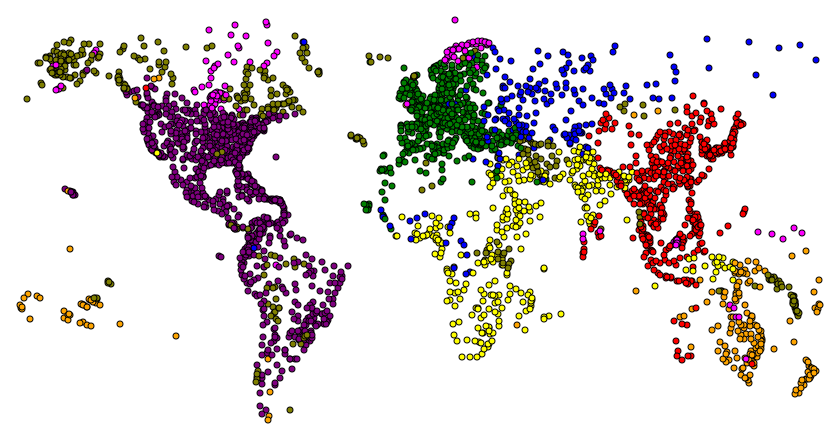

In [16]:
kmeans = KMeansDense(8)
labels = kmeans.fit_transform(embedding)
image = svg_graph(adjacency, position, labels=labels, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## 2. Directed graphs

## Wikipedia Vitals

We now consider a large directed graph. We use the class ``BiSpectral`` (i.e., the directed graph is viewed as a bipartite graph).

In [71]:
graph = wikivitals

In [72]:
adjacency = graph.adjacency
names = graph.names
labels = graph.labels_hierarchy
names_labels = graph.names_labels_hierarchy

## To do

* Check that the average cosine similarity between all node pairs in some set $S$ is given by the square norm of the barycenter of $S$.
* Give the average cosine similarity between nodes in the **Mammals** category.
* Compare with the expected cosine similarity between two nodes sampled uniformly at random.
* Defining a category as **topical** if its average cosine similarity is high, give the most topical category and the less topical category among all categories having at least 10 articles. 

In [103]:
spectral = BiSpectral(20, solver=HalkoEig(random_state=42), regularization=None, scaling=0)
spectral.fit(adjacency)

BiSpectral(n_components=20, regularization=None, relative_regularization=True, scaling=0, normalized=True, solver=HalkoEig(which='LM', n_oversamples=10, n_iter='auto', power_iteration_normalizer='auto', one_pass=False))

In [104]:
embedding = spectral.embedding_col_

#### Average cosine similarity between nodes in a set S == square norm of barycenter of S:

In [43]:
# we pick 100 random node
S = np.random.choice(range(len(names)), 100)

avg_sim = 0
for i in S:
    for j in S:
         avg_sim += cos_similarity(embedding[i], embedding[j])
avg_sim /= 100**2

barycenter = np.sum(embedding[S], axis = 0)/100
sq_norm = np.sum(np.power(barycenter, 2))

sq_norm, avg_sim

(0.0176513987541721, 0.017651398754172026)

#### Average similarity between nodes in the Mammals category:

In [149]:
mammal = 274

In [105]:
embedding.shape

(10012, 20)

In [192]:
avg_sim = 0
for i in np.where(labels == mammal)[0]:
    for j in np.where(labels == mammal)[0]:
        avg_sim += embedding[i].dot(embedding[j])
print("the average cos similarity between Mammals nodes is",avg_sim/len(np.where(labels == mammal)[0])**2)

the average cos similarity between Mammals nodes is 0.7952448716637677


#### Compare with the expected cosine similarity between two nodes sampled uniformly at random:

In [205]:
exp_sim = 0
for i in range(100):
    n1 = np.random.randint(adjacency.shape[0])
    n2 = np.random.randint(adjacency.shape[0])
    exp_sim += cos_similarity(embedding[n1], embedding[n2])
print("expected cosine similarity is", exp_sim/100)

expected cosine similarity is 0.00829549024966326


As expected, the cosine similarity is very low comparing to that of a cluster (a category).
___

#### Defining a category as *topical* if its average cosine similarity is high, give the most topical category and the less topical category among all categories having at least 10 articles:

In [48]:
def get_category(idx):
    if '.' in names_labels[idx]:
        return names_labels[idx][names_labels[idx].rindex('.')+1:]
    else:
        return names_labels[idx]

In [161]:
available_categories = np.unique(labels)
results = {}
for cat in available_categories:
    idx = np.where(labels == cat)[0]
    if len(idx) >= 10:
        avg_sim = 0
        for i in idx:
            for j in idx:
                avg_sim += embedding[i].dot(embedding[j])
        results[cat] = avg_sim / len(idx)**2

In [162]:
results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

In [163]:
results

{508: 0.9973656531771533,
 989: 0.9965030829438327,
 441: 0.994015080646748,
 1122: 0.9920527347415896,
 1260: 0.9912367848375279,
 970: 0.9902355269563707,
 563: 0.9877057208784653,
 131: 0.9871663645965773,
 754: 0.9848816607928128,
 811: 0.9847943516777825,
 514: 0.9840186061712809,
 512: 0.9836080264343241,
 559: 0.9828273726514778,
 876: 0.9825303239224208,
 419: 0.9825112303816852,
 63: 0.9738983955456293,
 1313: 0.9707190205886564,
 1049: 0.9696316242364565,
 567: 0.9689993967815795,
 284: 0.9676857593513637,
 489: 0.9646842445928029,
 1202: 0.9643228197372349,
 509: 0.9627737580917228,
 484: 0.9625712591363197,
 487: 0.9613340772721963,
 436: 0.9609868361585976,
 1459: 0.9602736980989904,
 224: 0.9598577424076749,
 454: 0.9583399666095848,
 1125: 0.9575944990326913,
 1063: 0.9574606532347915,
 92: 0.9531999436094641,
 1161: 0.9529175631408042,
 415: 0.9524981142665321,
 524: 0.9514198083113647,
 893: 0.951341365482669,
 901: 0.9485598964921318,
 581: 0.9484869941081193,
 406: 0

In [174]:
top = list(results)[0]
last = list(results)[-1]

print("the most topical category is", names_labels[top], "with a score of", results[top])
print("the least topical category is'", names_labels[last], "with a score of", results[last])

the most topical category is Geography.Countries.Africa.Central Africa with a score of 0.9973656531771533
the least topical category is' History.History by subject matter with a score of 0.1332541841310512


## 3. Bipartite graphs

Finally, we consider the co-embedding of each part of a bipartite graph. We focus on the bipartite graph formed by words used in the summaries of the articles of Wikivitals. 

## Wikipedia Vitals

In [242]:
graph = wikivitals

In [243]:
biadjacency = graph.biadjacency
articles = graph.names_row
words = graph.names_col

In [244]:
len(labels), len(articles), len(words)

(10012, 10012, 31323)

## To do

* What are now the most topical category and the less topical category among all categories having at least 10 articles?
* List the 10 most topical words associated with the most topical category, among all words used at least 10 times in the whole dataset.

In [245]:
words[biadjacency.indices[biadjacency.indptr[2000]:biadjacency.indptr[2001]]]

array(['intoler', 'larger', 'allergen', 'known', 'epinephrin', 'test',
       'environ', 'affect', 'metal', 'may', 'also', 'receptor', 'least',
       'amount', 'use', 'due', 'inflammatori', 'person', 'von', 'common',
       'poison', 'antihistamin', 'hay', 'adrenalin', 'world', 'problem',
       'immunoglobulin', 'atop', 'cell', 'insect', 'genet', 'depend',
       'histamin', 'immunotherapi', 'sting', 'bite', 'case', 'system',
       'allerg', 'increas', 'environment', 'recommend', 'protect',
       'treatment', 'medic', 'e', 'ige', 'dermat', 'rash', 'howev',
       'food', 'antibodi', 'basophil', 'hypersensit', 'releas', 'runni',
       'histori', 'time', 'condit', 'immun', 'sneez', 'skin', 'develop',
       'nose', 'caus', 'rate', 'anaphylaxi', 'includ', 'word', 'sever',
       'diseas', 'typic', 'point', 'separ', 'bodi', 'swell', 'allergi',
       'signific', 'substanc', 'symptom', 'trigger', 'reaction', 'eye',
       'mast', 'blood', 'part', 'short', 'appear', 'first', 'red',
    

In [246]:
spectral = BiSpectral(20, solver=HalkoEig(random_state=42), regularization=None, scaling=0)
spectral.fit(biadjacency)
X = spectral.embedding_
Y = spectral.embedding_col_

#### Most topical category and the less topical category among all categories having at least 10 articles:

In [274]:
available_categories = np.unique(labels)
results = {}
for cat in available_categories:
    idx = np.where(labels == cat)[0]
    if len(idx) >= 10:
        avg_sim = 0
        for i in idx:
            for j in idx:
                avg_sim += X[i].dot(X[j])
        results[cat] = avg_sim / len(idx)**2
results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

In [275]:
results

{989: 0.9887181689350839,
 1122: 0.9846443822788358,
 811: 0.9746071226888166,
 63: 0.9744914777836119,
 1125: 0.9713700306915118,
 876: 0.9705899863959344,
 754: 0.9700636861889913,
 935: 0.9578993942566273,
 1029: 0.9528273354898197,
 224: 0.9497263784730046,
 581: 0.9467717689088297,
 828: 0.9467441637933877,
 231: 0.9464564398122444,
 764: 0.9426297420769347,
 540: 0.9404726339447161,
 970: 0.9395080011861484,
 859: 0.9377210532628286,
 489: 0.9373327824892467,
 216: 0.9370383632733146,
 841: 0.9348132567317445,
 803: 0.9343794537514561,
 528: 0.9324801791292511,
 1063: 0.9312013830280021,
 879: 0.9243071870296408,
 436: 0.923944515970367,
 1089: 0.9195009362132045,
 881: 0.9177146964984849,
 376: 0.915741074420144,
 52: 0.9152844975843668,
 1161: 0.9121390496468857,
 515: 0.909908624968645,
 544: 0.9074199424045173,
 571: 0.907175229945818,
 487: 0.9063669092589577,
 559: 0.9053984026073142,
 838: 0.9051736153230936,
 524: 0.9035923460764017,
 490: 0.9033490602891261,
 516: 0.9023

In [276]:
top = list(results)[0]
last = list(results)[-1]

print("the most topical category is", names_labels[top], "with a score of", results[top])
print("the least topical category is", names_labels[last], "with a score of", results[last])

the most topical category is People.Sports figures.Team sports.Association football with a score of 0.9887181689350839
the least topical category is Arts.Architecture.Specific structures with a score of 0.24630184950275422


#### 10 most topical words associated with the most topical category, among all words used at least 10 times in the whole dataset:

In [212]:
results = {}
idx_top_cat = np.where(labels == top)[0]
for art in idx_top_cat:
    idx = biadjacency.indices[biadjacency.indptr[art]:biadjacency.indptr[art+1]]
    for word_idx in idx:
        if (np.sum(biadjacency[:,word_idx])>=10):
            avg_sim = 0
            for i in idx:
                for j in idx:
                    avg_sim += Y[i].dot(Y[j])
        results[word_idx] = avg_sim / len(idx)**2
results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True)) 

In [213]:
results

{18667: 0.38714366898847374,
 23805: 0.38714366898847374,
 27288: 0.38714366898847374,
 937: 0.38714366898847374,
 20712: 0.38714366898847374,
 20771: 0.38714366898847374,
 2828: 0.38714366898847374,
 8333: 0.38714366898847374,
 9535: 0.38714366898847374,
 9671: 0.38714366898847374,
 14397: 0.38714366898847374,
 14798: 0.38714366898847374,
 16291: 0.38714366898847374,
 16459: 0.38714366898847374,
 18929: 0.38714366898847374,
 20258: 0.38714366898847374,
 21274: 0.38714366898847374,
 23690: 0.38714366898847374,
 26239: 0.38714366898847374,
 1419: 0.37280295058119284,
 3319: 0.37280295058119284,
 4646: 0.37280295058119284,
 5420: 0.37280295058119284,
 8106: 0.37280295058119284,
 8984: 0.37280295058119284,
 10202: 0.37280295058119284,
 10233: 0.37280295058119284,
 14010: 0.37280295058119284,
 19818: 0.37280295058119284,
 20325: 0.37280295058119284,
 20926: 0.37280295058119284,
 21081: 0.37280295058119284,
 21790: 0.37280295058119284,
 22131: 0.37280295058119284,
 22348: 0.3728029505811928

In [217]:
print("the 10 most topical words in the most topical category are")
for i in range(10):
    print("-", words[list(results)[i]])

the 10 most topical words in the most topical category are
- period
- pair
- eccentr
- minor
- minori
- hipparco
- lie
- usual
- respect
- european


#### Most topical article in the most topical category:

In [277]:
print("the most topical category is", names_labels[top], "with a score of", results[top])

the most topical category is People.Sports figures.Team sports.Association football with a score of 0.9887181689350839


In [279]:
# get the article of the most topical category:
results = {}
idx = np.where(labels == 989)[0]
avg_sim = 0
for art in idx:
    avg_sim = 0
    for j in idx:
        avg_sim += X[art].dot(X[j])
    results[art] = avg_sim / len(idx)**2
results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True)) 

In [280]:
results

{6774: 0.0709299020258553,
 6769: 0.07088795782130301,
 6764: 0.07083720003622959,
 6771: 0.07082223195036344,
 6768: 0.07081271449356745,
 6773: 0.0708103619109399,
 6776: 0.07079576799808443,
 6770: 0.07077439633745342,
 6766: 0.0707134940886871,
 6765: 0.07067926163561095,
 6763: 0.07057129328359084,
 6772: 0.0702177516361114,
 6767: 0.07016420286532751,
 6775: 0.06970163285196032}

In [285]:
for key in results:
    print("-", articles[key])

- Cristiano Ronaldo
- Lionel Messi
- Johan Cruyff
- Michel Platini
- Diego Maradona
- Ronaldo (Brazilian footballer)
- Zinedine Zidane
- Pelé
- Eusébio
- Alfredo Di Stéfano
- Franz Beckenbauer
- Ferenc Puskás
- Mia Hamm
- Lev Yashin


In [283]:
articles[6774]

'Cristiano Ronaldo'